In [1]:
import numpy as np
import pandas as pd

from random import randint

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

from skimage.transform import resize

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout

from tqdm import tqdm_notebook

Using TensorFlow backend.


In [2]:
origin_size = 101
target_size = 128

def upsample(img):
    if origin_size == target_size:
        return img
    return resize(img, (target_size, target_size), mode = 'constant', preserve_range = True)

def downsample(img):
    if origin_size == target_size:
        return img
    return resize(img, (target_size, origin_size), mode = 'constant', preserve_range = True)

In [3]:
train_df = pd.read_csv("train.csv", index_col = "id", usecols = [0])
depths_df = pd.read_csv("depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

In [4]:
train_df["images"] = [np.array(load_img("train/images/{}.png".format(idx), grayscale = True)) / 255 for idx in tqdm_notebook(train_df.index)]

/home/gryffindorito/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [5]:
train_df["masks"] = [np.array(load_img("train/masks/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

In [6]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(origin_size, 2)

In [7]:
def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

In [8]:
ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train_df.index.values,
    np.array(train_df.images.map(upsample).tolist()).reshape(-1, target_size, target_size, 1), 
    np.array(train_df.masks.map(upsample).tolist()).reshape(-1, target_size, target_size, 1), 
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.2, stratify=train_df.coverage_class, random_state=1337)

Text(0.5, 1.0, 'Scaled image')

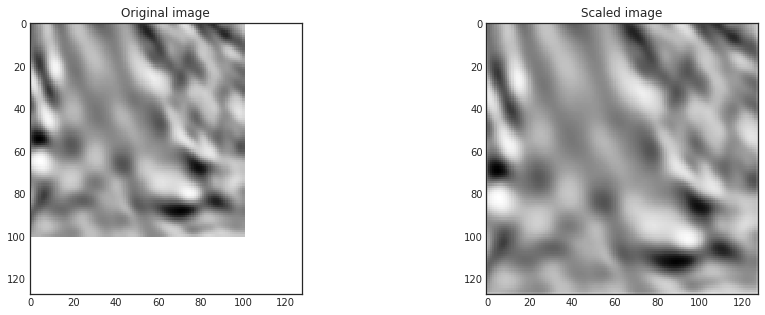

In [9]:
tmp_img = np.zeros((target_size, target_size), dtype=train_df.images.loc[ids_train[10]].dtype)
tmp_img[:origin_size, :origin_size] = train_df.images.loc[ids_train[10]]
fix, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].imshow(tmp_img, cmap="Greys")
axs[0].set_title("Original image")
axs[1].imshow(x_train[10].squeeze(), cmap="Greys")
axs[1].set_title("Scaled image")

In [10]:
def build_arch(input_layer, start_neurons):
    c1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    c1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(0.25)(p1)
    
    c2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(p1)
    c2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(0.5)(p2)
    
    c3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(p2)
    c3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(0.5)(p3)
    
    c4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(p3)
    c4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(c4)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(0.5)(p4)
    
    c5 = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(p4)
    c5 = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(c5)
    
    d4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(c5)
    u4 = concatenate([d4, c4])
    u4 = Dropout(0.5)(u4)
    u4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(u4)
    u4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(u4)
    
    d3 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(u4)
    u3 = concatenate([d3, c3])
    u3 = Dropout(0.5)(u3)
    u3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(u3)
    u3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(u3)
    
    d2 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(u3)
    u2 = concatenate([d2, c2])
    u2 = Dropout(0.5)(u2)
    u2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(u2)
    u2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(u2)
    
    d1 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(u2)
    u1 = concatenate([d1, c1])
    u1 = Dropout(0.5)(u1)
    u1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(u1)
    u1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(u1)
    
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(u1)
    
    return output_layer

input_layer = Input((target_size, target_size, 1))
output_layer = build_arch(input_layer, 16)
    

In [11]:
model = Model(input_layer, output_layer)

In [12]:
model.compile( loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [13]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 16) 2320        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 64, 64, 16)   0           conv2d_2[0][0]                   
____________________________________________________________________________________________

In [14]:
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)

In [ ]:
early_stopping = EarlyStopping(patience = 10, verbose = 1)
model_checkpoint = ModelCheckpoint("./keras.model", save_best_only = True, verbose = 1)
reduce_lr = ReduceLROnPlateau(factor = 0.1, patience = 5, min_lr = 0.00001, verbose = 1)

epochs = 200
batch_size = 32

history = model.fit(x_train, y_train, validation_data = [x_valid, y_valid], epochs = epochs, batch_size = batch_size, callbacks=[early_stopping, model_checkpoint, reduce_lr])